In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_magjudge')
save_params_folder = op.join(bids_folder,'derivatives/phenotype')

sns.set_context('talk')

from utils import get_data

df = get_data(bids_folder, include_var=['group','age'])
df['x'] = df['log(n2/n1)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']]


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [32]:
model_label = 1
model = bambi.Model('chose_n2 ~ x + x*group + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [24]:
model_label = 2
model = bambi.Model('chose_n2 ~ x + x*n1*group + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [2]:
model_label = 3
model = bambi.Model('chose_n2 ~ x + x*C(n1)*group + (x*C(n1)|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [2]:
model_label = 4

model = bambi.Model('chose_n2 ~ x + n1 + n1:x + x:age + group:n1 + x:group:age + x:group:n1 + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [6]:
model_label = 5

model = bambi.Model('chose_n2 ~ x + n1 + group + x:group + x:n1 + x:age + group:n1 + x:group:age + x:group:n1 + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [10]:
model_label = 'startSimple1'

model = bambi.Model('chose_n2 ~ x + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [95]:
model_label = 'startSimple2' # not hierachical to get subjectwise gammas --> look at age and IQ effects

model = bambi.Model('chose_n2 ~ 0 + C(subject) + x:C(subject)', link='probit', family='bernoulli', data=df.reset_index())

### fit

In [96]:
import arviz as az

traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

az.to_netcdf(traces, op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))

Modeling the probability that chose_n2==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C(subject), x:C(subject)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.


'/Users/mrenke/data/ds-dnumrisk/derivatives/cogmodels_magjudge/probit_model-startSimple2_trace.netcdf'

### load in trace

In [22]:
import arviz as az

model_label = 4

traces = az.from_netcdf( op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))


5
Intercept: mean=-0.40246104901290736, 95%CI=[-0.53209604 -0.26929214]
x: mean=2.8348860338585573, 95%CI=[0.33033191 5.29351066]
n1: mean=0.03404425685863614, 95%CI=[0.02391257 0.04429664]
group: mean=-0.09769567890751965, 95%CI=[-0.28249965  0.07843612]
x:group: mean=3.288906276063596, 95%CI=[-0.39252973  6.95518376]
x:n1: mean=-0.10238633647871952, 95%CI=[-0.13170858 -0.07173923]
x:age: mean=0.13175956414369938, 95%CI=[0.00742309 0.26103496]
group:n1: mean=0.013379698753620658, 95%CI=[-0.00071752  0.02774808]
x:group:age: mean=-0.20371736260824305, 95%CI=[-0.38965803 -0.0148026 ]
x:group:n1: mean=0.031102469773258416, 95%CI=[-0.01205953  0.07211197]


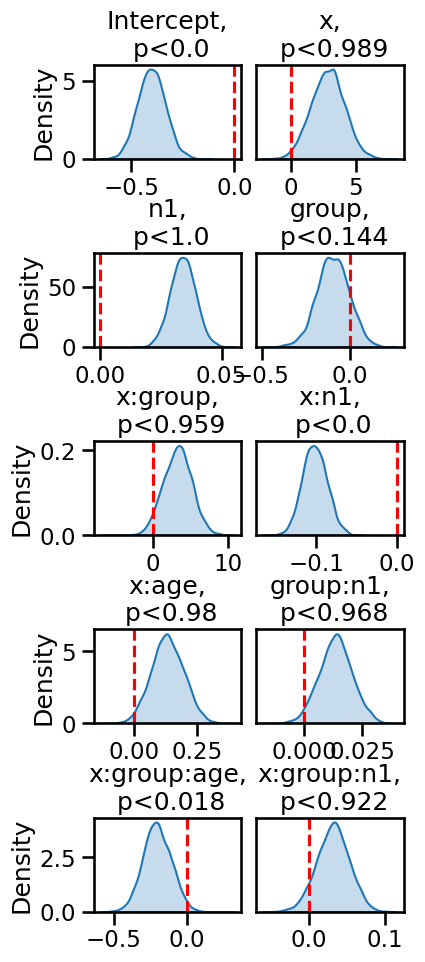

In [8]:
print(model_label)

variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,n_rows * 2.2), sharex=False)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=1)
plt.savefig(op.join(plot_folder, f'probit_model-{model_label}_regressors.pdf'))

In [12]:
from utils import extract_rnp_precision

intercept, gamma= extract_rnp_precision(traces, model,df, group_level = False) # ,group=False for subs

intercept = intercept.stack([1, 2])
intercept.columns = ['intercept']

gamma = gamma.stack([1, 2])
gamma.columns = ['gamma']

#gamma.groupby('subject').mean().to_csv(op.join(save_params_folder, f'gamma-magjudge_probit-{model_label}.csv'))

### group level

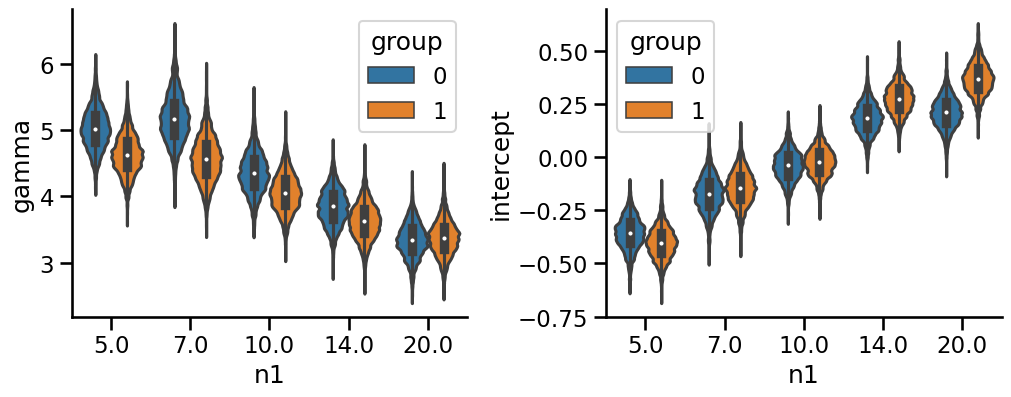

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(data=gamma.reset_index(), x='n1',y='gamma',hue='group',ax=axs[0])
sns.violinplot(data=intercept.reset_index(), x='n1',y='intercept',hue='group',ax=axs[1])
plt.subplots_adjust(wspace=0.35)
sns.despine()


Text(51.0, 0.5, 'density - gamma')

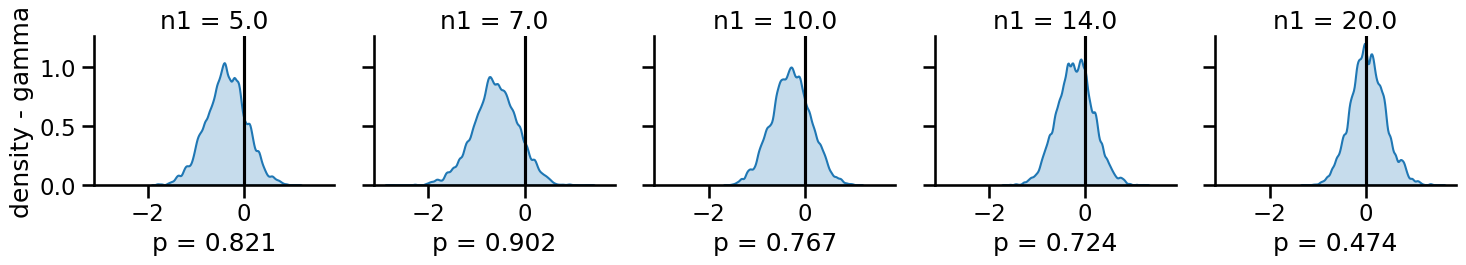

In [6]:
temp = gamma.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')

for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - gamma')


Text(51.0, 0.5, 'density - intercept')

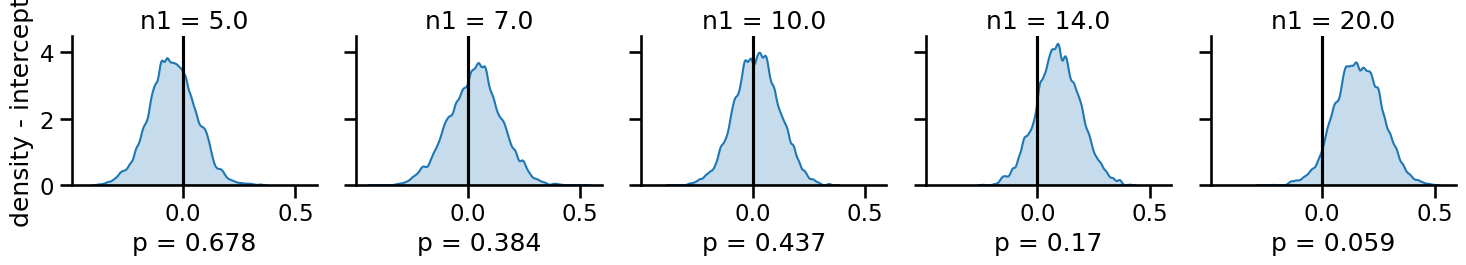

In [7]:
temp = intercept.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')


for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - intercept')


#### subject level

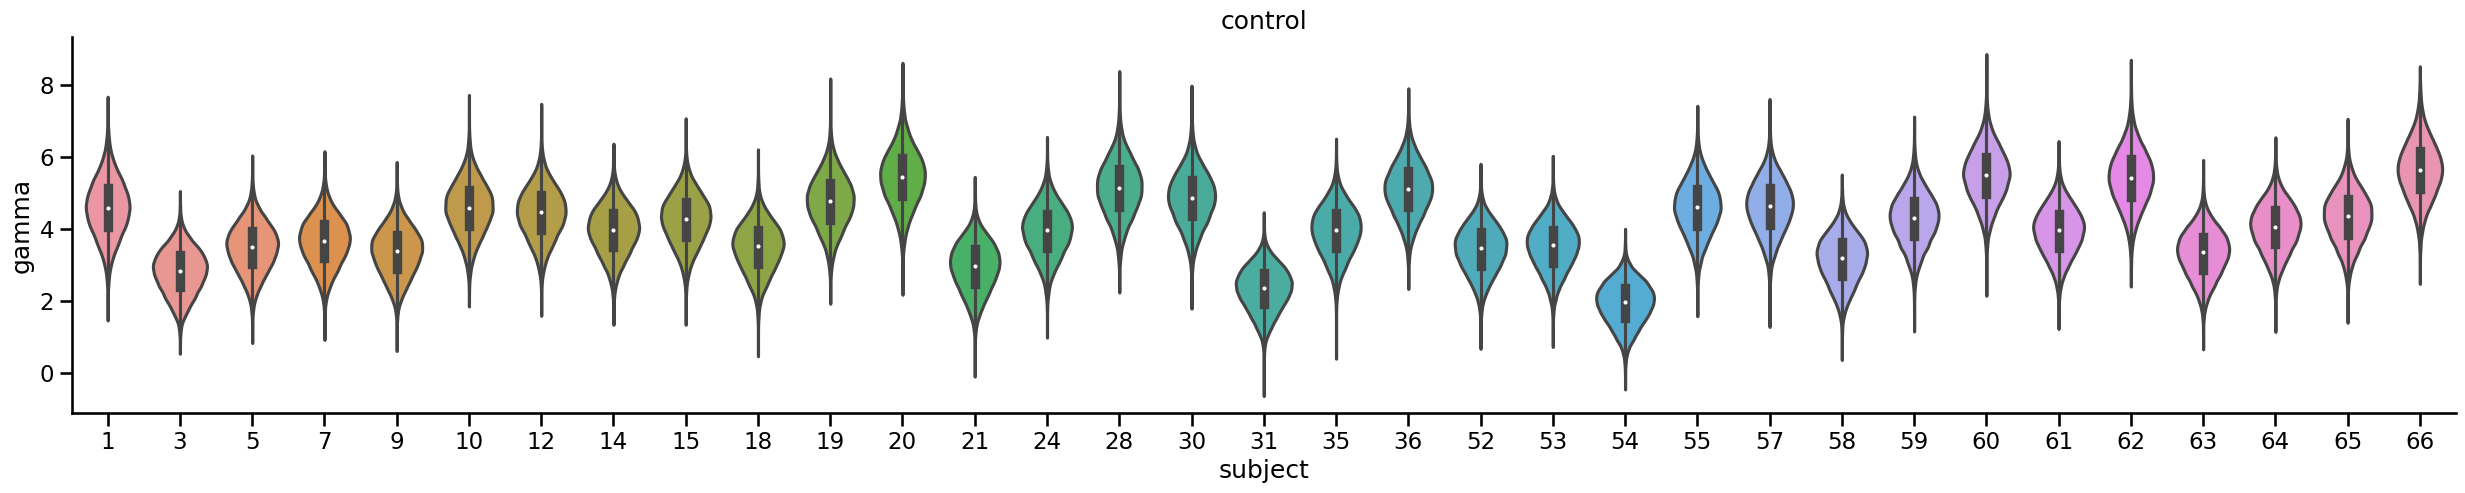

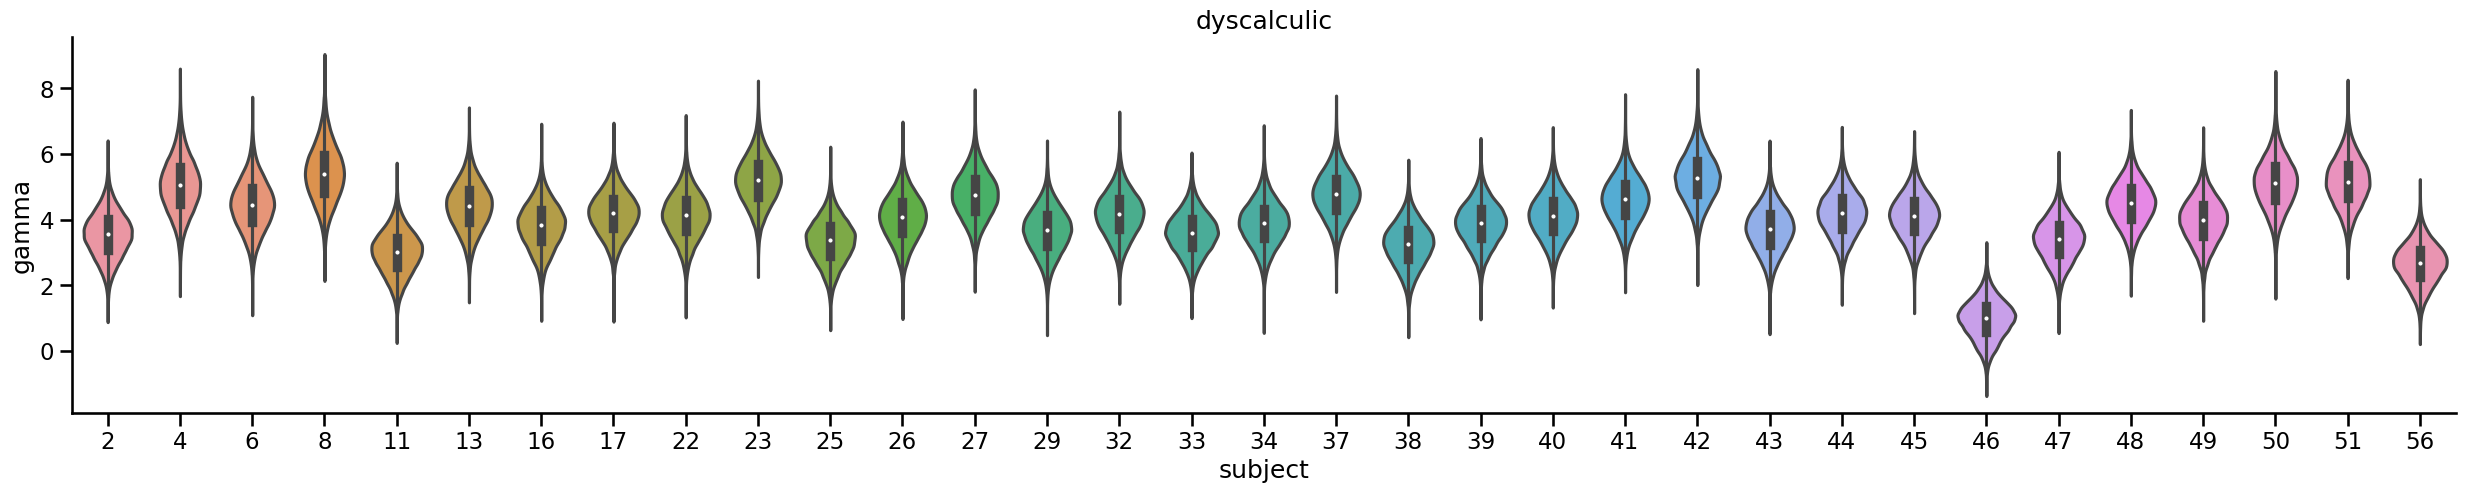

In [26]:

for i, group in enumerate(['control','dyscalculic']):
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = gamma[gamma.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='gamma', data=temp.reset_index(), aspect=5., kind='violin')
    fac.set(title=f'{group}') 

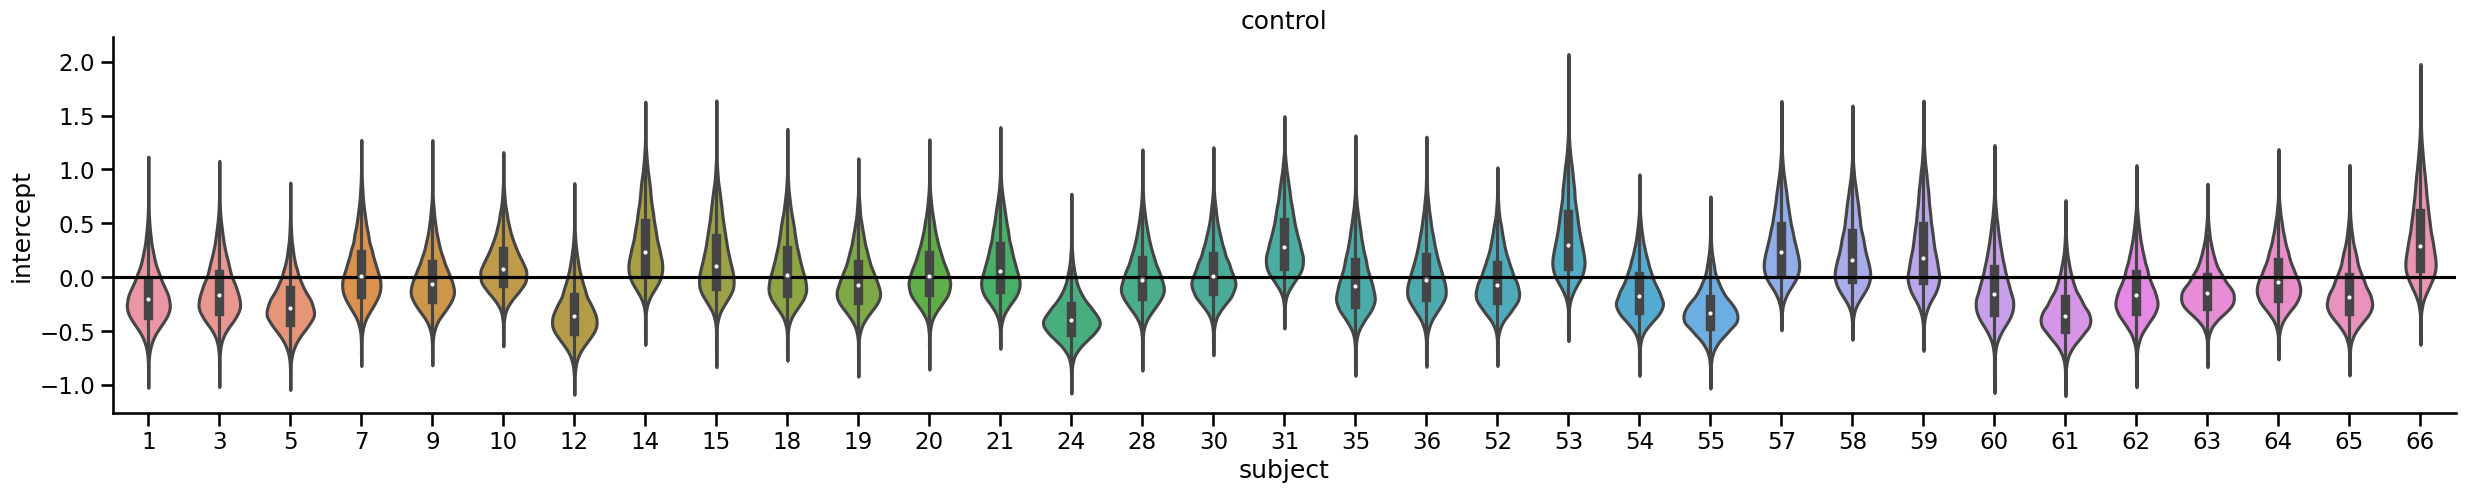

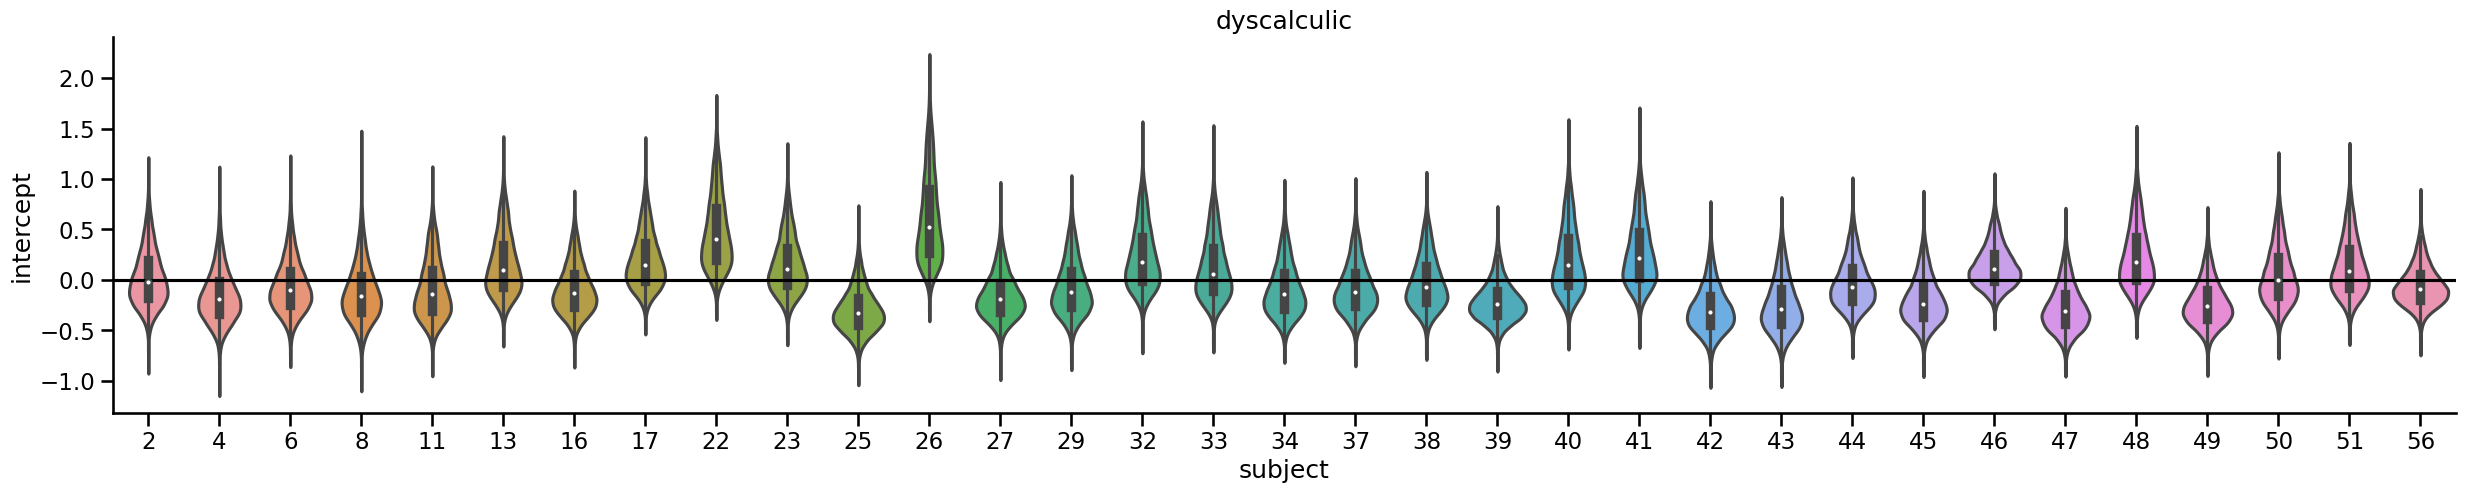

In [27]:

for i, group in enumerate(['control','dyscalculic']):
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = intercept[intercept.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='intercept', data=temp.reset_index(), aspect=5., kind='violin')
    plt.axhline(0, c='k')
    fac.set(title=f'{group}') #, ylabel='Risk neutral probability')
    #fac.add_legend()

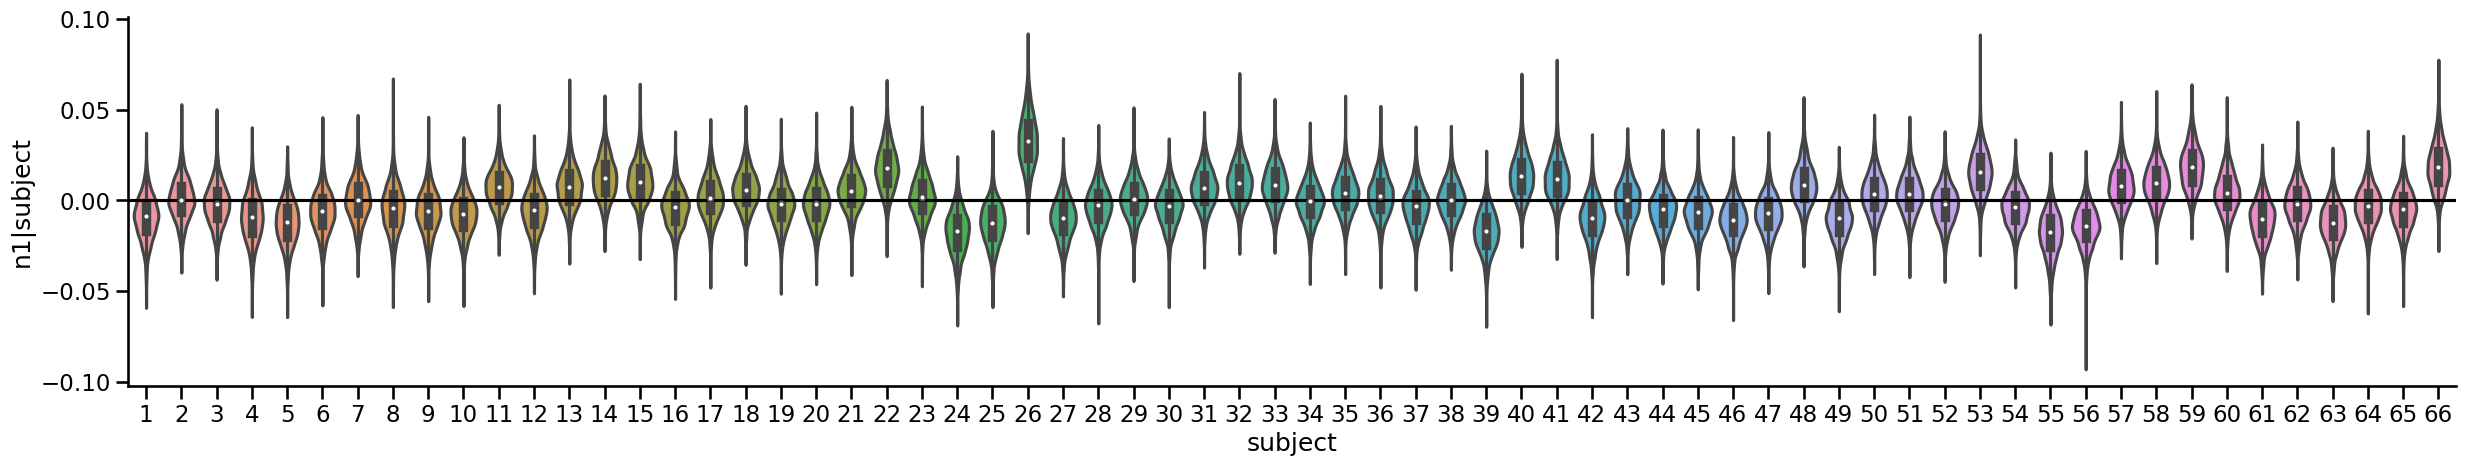

In [39]:
sub_n1effect = traces.posterior['n1|subject'].to_dataframe().rename_axis(index={'subject__factor_dim':'subject'})
fac = sns.catplot(x='subject', y='n1|subject', data=sub_n1effect.reset_index(), aspect=5., kind='violin')
plt.axhline(0,c='k')
sub_n1effect.groupby('subject').mean().to_csv(op.join(save_params_folder, 'probit-2_subwise_number-range-effects.csv'))


In [52]:
s = sub_n1effect.groupby('subject').mean()
#s = s.sort_index().sample(frac=1)
s.index = s.index.astype(int)
s.join(params_comb, on='subject')

,n1|subject,gamma,intercept
subject,,,
1,-0.009172,4.583617,-0.177108
10,-0.007533,4.574363,0.109705
11,0.007274,3.000321,-0.090343
12,-0.005493,4.438255,-0.328638
13,0.007469,4.417567,0.155715
...,...,...,...
65,-0.005014,4.331327,-0.144134
66,0.018809,5.638005,0.359191
7,0.000317,3.644972,0.049478


In [57]:
sub_n1effect = sub_n1effect.groupby('subject').mean()
sub_n1effect.index = sub_n1effect.index.astype(int)

params_comb = gamma.groupby('subject').mean().join(intercept.groupby('subject').mean()).join(sub_n1effect)
params_comb.to_csv(op.join(save_params_folder, 'probit-2_all-subwise-params.csv'))


In [ ]:
for i, group in enumerate(['control','dyscalculic']):
    plt.figure()
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = rnp[rnp.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='rnp', data=temp.reset_index(), hue='format', aspect=5., kind='violin')
    plt.ylim(0, 1)
    plt.axhline(.55, c='k', ls='--', label='risk-neutral')
    fac.set(title=f'{group}', ylabel='Risk neutral probability')
    fac.add_legend()

## PPCs

In [34]:
def format_bambi_ppc(trace, model, df):

    preds = []
    for key, kind in zip(['ll_bernoulli', 'p'], ['pps', 'mean']):
        pred = model.predict(trace, kind=kind, inplace=False) 
        if kind == 'pps':
            pred = pred['posterior_predictive']['chose_n2'].to_dataframe().unstack(['chain', 'draw'])['chose_n2']
        else:
            pred = pred['posterior']['chose_n2_mean'].to_dataframe().unstack(['chain', 'draw'])['chose_n2_mean']
        pred.index = df.index
        pred = pred.set_index(pd.MultiIndex.from_frame(df), append=True)
        preds.append(pred)

    pred = pd.concat(preds, keys=['ll_bernoulli', 'p'], names=['variable'])
    return pred

In [ ]:
from utils_03 import  summarize_ppc, plot_ppc, format_bambi_ppc

ppc = format_bambi_ppc(traces, model, df)
summarize_ppc(ppc, groupby=None)


In [ ]:
level = 'group' # 'subject'
for plot_type in [1,2,3]:
    plot_ppc(df, ppc,level=level, plot_type=plot_type)
    plt.savefig(op.join(plot_folder, f'ppc_rnp_model-{model_label}_plot-{plot_type}_{level}.pdf'))
    plt.close()